# Problem Set #5

Ariel Boyarsky

aboyarsky@uchicago.edu

a. Use a multinomial logistic regression model of the following form with the
following linear predictor $η_j$ for j = 1, 2 (the baseline class is j = 3).

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut, KFold
import statsmodels.api as sm
from scipy.interpolate import LSQUnivariateSpline

In [8]:
dta = pd.read_csv("strongdrink.txt")
dta['const'] = 1

In [9]:
dta.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline,const
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [10]:
X = dta[['const', 'alco', 'malic', 'tot_phen', 'color_int']]
y = dta['cultivar']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)

LR = LogisticRegression(multi_class='multinomial', solver='newton-cg')
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



In [15]:
for j in range(2):
    print("The coefficents for j = "+ str(j+1) + " are " + str(LR.coef_[j]))

The coefficents for j = 1 are [ -8.45998059e-06   1.70038994e+00  -2.65604001e-01   1.22389318e+00
   2.27585993e-02]
The coefficents for j = 2 are [ -1.76923786e-05  -1.46805313e+00  -3.33053748e-01   6.64013944e-01
  -9.22712974e-01]


In [16]:
LR.intercept_

array([-24.0108148,  22.8025761,   1.2082387])

In [17]:
dta.cultivar.value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

In [18]:
MSE_vs = ((y_test - y_pred) ** 2).sum() / y_pred.shape[0]
print('Validation set MSE = ', MSE_vs)

Validation set MSE =  0.045454545454545456


The error rate for $j=1$ is 0.03, for $j=2$ is 0, for $j=3$ is 0. It is best at predicting $j=3$. No, it has the least observations. Though $j=2$ is also very good and has the most.

b. Perform a leave-one-out cross validation (LOOCV) with the model from
part (a). Report your error rates (1 - precision) for each category? How
do your error rates compare to those from part (a)? Report your LOOCV
estimate for the test MSE as the average MSE, where yi
is the left out
observation from each test set.


In [20]:
X = dta[['const', 'alco', 'malic', 'tot_phen', 'color_int']].values
y = dta['cultivar'].values
N = X.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(X)
MSE = np.zeros(N)
y_test_vec = np.zeros(N)
y_pred_vec = np.zeros(N)

In [21]:
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE[test_index] = (y_test - y_pred) ** 2
    y_pred_vec[test_index] = y_pred
    y_test_vec[test_index] = y_test

In [11]:
MSE_loo = MSE.mean()
MSE_loo_std = MSE.std()
print('test estimate MSE loocv=', MSE_loo,
      ', test estimate MSE standard err=', MSE_loo_std)

test estimate MSE loocv= 0.0965909090909 , test estimate MSE standard err= 0.394262505894


In [22]:
print(classification_report(y_test_vec, y_pred_vec))

             precision    recall  f1-score   support

        1.0       0.90      0.93      0.92        59
        2.0       0.91      0.90      0.91        71
        3.0       0.96      0.93      0.95        46

avg / total       0.92      0.92      0.92       176



Then clearly the error terms are 0.1, 0.09, 0.04 for j = 1,2,3 respectivley. These are higher than in part (a).

c. Perform a k-fold cross validation in which the data are divided into k = 4
groups. Use the following code. Report your error rates (1 - precision)
for each category. How do your error rates compare to those from parts
(a) and (b)? Report your k-fold estimate for the test MSE as the average
MSE.

In [25]:
X = dta[['const', 'alco', 'malic', 'tot_phen', 'color_int']].values
y = dta['cultivar'].values
k=4
kf = KFold(n_splits=k, shuffle=True, random_state=10)
kf.get_n_splits(X)

4

In [33]:
MSE_vec_kf = np.zeros(k)
y_test_vec = np.array([])
y_pred_vec = np.array([])

k_ind = int(0)
for train_index, test_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    print('k index=', k_ind)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_test_vec = np.append(y_test_vec, y_test)
    LogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    y_pred_vec = np.append(y_pred_vec, y_pred)
    MSE_vec_kf[k_ind] = ((y_test - y_pred) ** 2).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

k index= 0
MSE for test set 0  is 0.227272727273
k index= 1
MSE for test set 1  is 0.113636363636
k index= 2
MSE for test set 2  is 0.0454545454545
k index= 3
MSE for test set 3  is 0.0454545454545
test estimate MSE k-fold= 0.107954545455 test estimate MSE standard err= 0.0742994138104


In [35]:
print(classification_report(y_test_vec, y_pred_vec))

             precision    recall  f1-score   support

        1.0       0.87      0.93      0.90        59
        2.0       0.91      0.87      0.89        71
        3.0       0.96      0.93      0.95        46

avg / total       0.91      0.91      0.91       176



For $j=1$ the error rates are 0.29, 0, 0.06, 0.12. For $j=2$, the rates are 0, .31, 0.06, 0. For $j=3$ the rates are 0.22, 0, 0, 0. These are worse then in part 1. On average about the same as part (b).

## 2. Splines Interpolation

a. Create a scatterplot of the data with age on the x-axis and Coolness Index
on the y-axis. Label your axes, and give the plot a title.

In [38]:
cool = pd.read_csv("Coolindex.txt", header=None)
cool.columns = ["age", "coolness_index"]
min(cool.age)

11.0

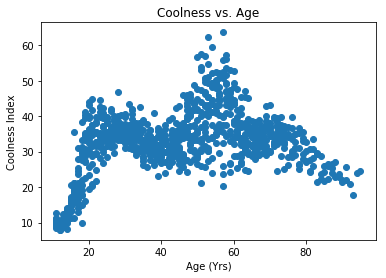

In [39]:
plt.scatter(x=cool.age, y=cool.coolness_index)
plt.xlabel("Age (Yrs)")
plt.ylabel("Coolness Index")
plt.title("Coolness vs. Age")
plt.show()

b.Use ordinary least squares (OLS) regression to fit a stepwise function to
these data. Use 5 bins [11, 22), [22, 40), [40, 59), [59, 77), [77, 95]. Remember
that your dummy variables must be integer type (0, 1), not boolean
type (True, False). Plot this step function on top of the scatterplot of
the data from part (a). Label your axes, include a legend, and give the
plot a title. Report your estimated step function values for each bin
[β1, β2, β3, β4, β5]. What is the predicted coolness of a 73-year old from
the stepwise function?


In [45]:
index = cool['coolness_index']
age = cool['age']
age_bin1 = (age < 22).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = ((age >= 77) & (age < 95)).astype(int)

In [46]:
X_step = pd.DataFrame(dict(age_bin1=age_bin1, age_bin2=age_bin2,
                           age_bin3=age_bin3, age_bin4=age_bin4,
                           age_bin5=age_bin5))
X_step.describe()

,age_bin1,age_bin2,age_bin3,age_bin4,age_bin5
count,956.000000,956.000000,956.000000,956.000000,956.000000
mean,0.162134,0.276151,0.285565,0.217573,0.057531
std,0.368767,0.447326,0.451919,0.412812,0.232977
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
reg = sm.OLS(endog=index, exog=X_step, missing='drop')
reg_results = reg.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:         coolness_index   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     4280.
Date:                Sun, 18 Feb 2018   Prob (F-statistic):               0.00
Time:                        22:27:31   Log-Likelihood:                -3220.5
No. Observations:                 956   AIC:                             6451.
Df Residuals:                     951   BIC:                             6475.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      20.1025      0.566     35.522      0.0

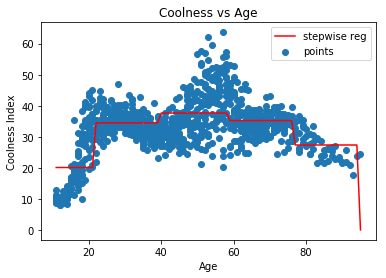

In [52]:
plt.scatter(age, index, label="points")
plt.plot(cool.age, reg_results.predict(X_step), color = 'r',label='stepwise reg')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness vs Age')
plt.show()

In [66]:
b1, b2, b3, b4, b5 = reg_results.params
print('beta_1 =', b1, ', beta_2 =', b2,
      ', beta_3 =', b3, ', beta_4 =', b4,
      ', beta_5 =', b5)
print('Thus, the predicted coolness for a 73-year old would be', b4)

beta_1 = 20.1024572521 , beta_2 = 34.4757880776 , beta_3 = 37.6351054924 , beta_4 = 35.2254000402 , beta_5 = 27.3481669528
Thus, the predicted coolness for a 73-year old would be 35.2254000402


c. Fit a linear spline (continuous) to the data over the 5 age bins from part (b).
Use the scipy.interpolate.LQUnivariateSpline function with k = 1
(linear) and the knots equal to t =[22,40,59,77]. Plot your continuous
linear spline against a scatterplot of the data from part (a) and the estimated
step function from part (b). Label your axes, include a legend, and
give the plot a title. What is the predicted coolness of a 73-year old from
the linear spline?

In [67]:
knots = [22, 40, 59, 77]
spline = LSQUnivariateSpline(age.values, index.values, knots, k=1)
pred_1 = spline(age)

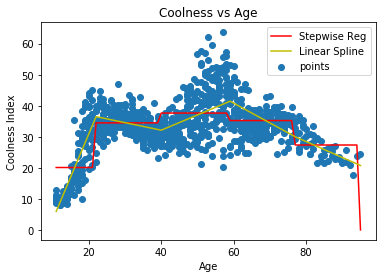

In [70]:
plt.scatter(age, index, label="points")
plt.plot(cool.age, reg_results.predict(X_step), color = 'r',label='Stepwise Reg')
plt.plot(cool.age, pred_1, color='y', label='Linear Spline')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness vs Age')
plt.show()

In [71]:
print('Thus, the predicted coolness for a 73-year old would be', spline(73))

Thus, the predicted coolness for a 73-year old would be 32.536832389143306


d. Fit a cubic spline (continuous) to the data over the 5 age bins from part (b).
Use the scipy.interpolate.LQUnivariateSpline function with k = 3
(cubic) and the knots equal to t =[22,40,59,77]. Plot your continuous
cubic spline against a scatterplot of the data from part (a) and the estimated
step function from part (b), and the linear spline from part (c).
Label your axes, include a legend, and give the plot a title. What is the
predicted coolness of a 73-year old from the cubic spline?


In [72]:
knots = [22, 40, 59, 77]
spline = LSQUnivariateSpline(age.values, index.values, knots, k=3)
pred_3 = spline(age)

In [ ]:
plt.scatter(age, index, label="points")
plt.plot(cool.age, reg_results.predict(X_step), color = 'r',label='Stepwise Reg')
plt.plot(cool.age, pred, color='y', label='Linear Spline')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness vs Age')
plt.show()

# References
Evans, Rick. Resampling Methods (MACS 30100). Feburary, 2018. https://github.com/UC-MACSS/persp-model_W18/blob/master/Notebooks/Resampling/Resampling.ipynb.